<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Current weather data: divergent and rotational decomposition on the sphere</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

Uses [MetPy](https://unidata.github.io/MetPy/latest/) (maybe not) and [Siphon](https://unidata.github.io/siphon/latest/) and [xarray](https://xarray.pydata.org/en/stable/index.html) and [windspharm](https://ajdawson.github.io/windspharm/latest/). Writes .nc file to local directory. 

In [80]:
# for test plots
%matplotlib inline 

# 1 degree data is fine enough
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_onedeg/catalog.xml?dataset=grib/NCEP/GFS/Global_onedeg/Best')
best_gfs.datasets

['Best GFS One Degree Forecast Time Series']

In [81]:
best_ds = list(best_gfs.datasets.values())[0]
ncss = best_ds.subset()
query = ncss.query()

We can look at the `ncss.variables` object to see what variables are available from the dataset:

In [100]:
# ncss.variables        # long list

## Take current data, global, u and v

In [101]:
from datetime import datetime

query.time(datetime.utcnow())

# query.vertical_level(20000) # Pascals? Yes according to this example, but CAREFUL!
# https://unidata.github.io/siphon/latest/examples/ncss/NCSS_Timeseries_Examples.html?highlight=vertical

query.accept('netcdf4')
query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric', 'Geopotential_height_isobaric')


var=Geopotential_height_isobaric&var=u-component_of_wind_isobaric&var=v-component_of_wind_isobaric&time=2021-09-07T14%3A37%3A02.547278&accept=netcdf4

### We now request data from the server using this query. 
The `NCSS` class handles parsing this NetCDF data (using the `netCDF4` module). If we print out the variable names, we see our requested variables, as well as a few others (more metadata information)

In [102]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))

list(data)

['Geopotential_height_isobaric',
 'LatLon_Projection',
 'u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric']

In [103]:
u = data['u-component_of_wind_isobaric'] #.squeeze() # squeeze off the time dimension
v = data['v-component_of_wind_isobaric'] #.squeeze()
Z = data['Geopotential_height_isobaric'] #.squeeze()

In [91]:
u.isobaric1.values[20]/100.    # levels are called isobaric1 

100.0

In [110]:
v.sel(isobaric1=10000)   # quick look

<xarray.DataArray 'v-component_of_wind_isobaric' (time: 1, lat: 181, lon: 360)>
array([[[ 7.098228,  7.138227, ...,  7.008227,  7.058228],
        [11.608228, 11.638227, ..., 11.518228, 11.568228],
        ...,
        [ 0.328228,  0.398228, ...,  0.168228,  0.248228],
        [-1.941772, -1.791772, ..., -2.231772, -2.081773]]], dtype=float32)
Coordinates:
    reftime    (time) datetime64[ns] ...
  * time       (time) datetime64[ns] 2021-09-07T15:00:00
    isobaric1  float32 1e+04
  * lat        (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Attributes:
    long_name:                      v-component of wind @ Isobaric surface
    units:                          m/s
    abbreviation:                   VGRD
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-2-3_L100
    Grib2_Parameter:                [0 2 3]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Momentum
    Grib2_Parameter_Name:           v-component of wind
    Grib2_Level_Type:               100
    Grib2_Level_Desc:               Isobaric surface
    Grib2_Generating_Process_Type:  Forecast

# Ready for the processing loop and write-out

In [111]:
import windspharm

In [112]:
V = windspharm.xarray.VectorWind(u,v)   # seems to work for all levels
# V      #<windspharm.xarray.VectorWind at 0x162d7ea90>

In [113]:
psi = V.streamfunction()
chi = V.velocitypotential()
Vdiv= V.irrotationalcomponent()
Vrot= V.nondivergentcomponent()

In [116]:
psi

<xarray.DataArray 'streamfunction' (time: 1, isobaric1: 41, lat: 181, lon: 360)>
array([[[[ 7.0755280e+06,  7.0755280e+06,  7.0755280e+06, ...,
           7.0755280e+06,  7.0755280e+06,  7.0755280e+06],
         [ 8.7598360e+06,  8.8138560e+06,  8.8672800e+06, ...,
           8.5944240e+06,  8.6501080e+06,  8.7052520e+06],
         [ 9.8670000e+06,  9.9732000e+06,  1.0078200e+07, ...,
           9.5415640e+06,  9.6511480e+06,  9.7596360e+06],
         ...,
         [ 9.2638680e+07,  9.2605104e+07,  9.2571904e+07, ...,
           9.2741824e+07,  9.2707024e+07,  9.2672656e+07],
         [ 9.3577360e+07,  9.3556192e+07,  9.3535392e+07, ...,
           9.3643048e+07,  9.3620800e+07,  9.3598896e+07],
         [ 9.5027152e+07,  9.5027152e+07,  9.5027152e+07, ...,
           9.5027152e+07,  9.5027152e+07,  9.5027152e+07]],

        [[ 4.3270840e+06,  4.3270840e+06,  4.3270840e+06, ...,
           4.3270840e+06,  4.3270840e+06,  4.3270840e+06],
         [ 5.6706080e+06,  5.7113280e+06,  5.7515560e+06, ...,
           5.5456000e+06,  5.5877400e+06,  5.6294040e+06],
         [ 6.4701960e+06,  6.5447320e+06,  6.6183200e+06, ...,
           6.2410640e+06,  6.3183400e+06,  6.3947280e+06],
...
           8.6902760e+06,  8.6770020e+06,  8.6637500e+06],
         [ 8.5882410e+06,  8.5817040e+06,  8.5751400e+06, ...,
           8.6076550e+06,  8.6012220e+06,  8.5947480e+06],
         [ 8.6323120e+06,  8.6323120e+06,  8.6323120e+06, ...,
           8.6323120e+06,  8.6323120e+06,  8.6323120e+06]],

        [[ 9.4681100e+06,  9.4681100e+06,  9.4681100e+06, ...,
           9.4681100e+06,  9.4681100e+06,  9.4681100e+06],
         [ 8.8158830e+06,  8.8300920e+06,  8.8444610e+06, ...,
           8.7742390e+06,  8.7879540e+06,  8.8018360e+06],
         [ 8.1079010e+06,  8.1359265e+06,  8.1640095e+06, ...,
           8.0242570e+06,  8.0520550e+06,  8.0799410e+06],
         ...,
         [ 4.8984590e+06,  4.8857695e+06,  4.8731405e+06, ...,
           4.9367870e+06,  4.9239790e+06,  4.9111990e+06],
         [ 4.8504180e+06,  4.8440780e+06,  4.8377135e+06, ...,
           4.8692535e+06,  4.8630100e+06,  4.8567300e+06],
         [ 4.9029535e+06,  4.9029535e+06,  4.9029535e+06, ...,
           4.9029530e+06,  4.9029530e+06,  4.9029530e+06]]]],
      dtype=float32)
Coordinates:
  * lat        (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 2021-09-07T15:00:00
  * isobaric1  (isobaric1) float32 1.0 2.0 4.0 7.0 ... 9.5e+04 9.75e+04 1e+05
Attributes:
    units:          m**2 s**-1
    standard_name:  atmosphere_horizontal_streamfunction
    long_name:      streamfunction

In [118]:
# chi.sel(isobaric1=20000).plot()    # quick look at 200 hPa level

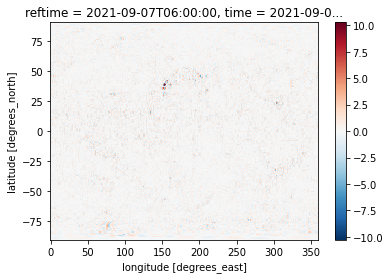

In [122]:
# Test the completeness of the decomposition: just speckle (gridscale noise) mostly
udif = u - Vrot[0]-Vdiv[0]
vdif = v - Vrot[1]-Vdiv[1]
vdif.sel(isobaric1=20000).plot()

In [123]:
Windspharm_outputs = chi.to_dataset()

In [126]:
Windspharm_outputs['streamfunction'] = psi
Windspharm_outputs['geopotential'] = Z
Windspharm_outputs['urot'] = Vrot[0]
Windspharm_outputs['vrot'] = Vrot[1]
Windspharm_outputs['udiv'] = Vdiv[0]
Windspharm_outputs['vdiv'] = Vdiv[1]
Windspharm_outputs['u'] = u
Windspharm_outputs['v'] = v

In [127]:
Windspharm_outputs.to_netcdf('test.nc')

In [130]:
Z.attrs # would like to work with 'Grib2_Parameter_Category' for IDV but life is too short

{'long_name': 'Geopotential height @ Isobaric surface',
 'units': 'gpm',
 'abbreviation': 'HGT',
 'grid_mapping': 'LatLon_Projection',
 'Grib_Variable_Id': 'VAR_0-3-5_L100',
 'Grib2_Parameter': array([0, 3, 5], dtype=int32),
 'Grib2_Parameter_Discipline': 'Meteorological products',
 'Grib2_Parameter_Category': 'Mass',
 'Grib2_Parameter_Name': 'Geopotential height',
 'Grib2_Level_Type': 100,
 'Grib2_Level_Desc': 'Isobaric surface',
 'Grib2_Generating_Process_Type': 'Forecast'}

# Some global analyses 
1. Are Vrot and Vdiv globally orthogonal? 

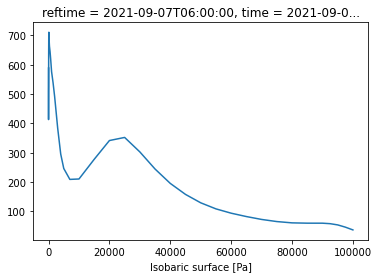

In [156]:
KE = (u*u + v*v)/2
KE.mean(dim=['lat','lon']).plot()

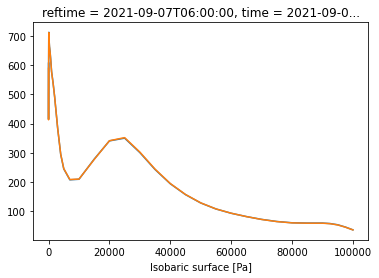

In [182]:
KEdiv = (Vdiv[0]*Vdiv[0] + Vdiv[1]*Vdiv[1])/2
KErot = (Vrot[0]*Vrot[0] + Vrot[1]*Vrot[1])/2

# Plot KE of Vrot, Vdiv, and total 
(KErot + KEdiv).mean(dim=['lat','lon']).plot()
KE.mean(dim=['lat','lon']).plot() 

In [ ]:
# Oh I can make a flow with much more divergence and see if this still agrees 

In [196]:
Vdivbig = Vdiv.copy()
Vdivbig[0]= Vdiv[0]*10
Vdivbig[1]= Vdiv[1]*10

Vtest = Vrot + Vdivbig

KEdivbig = (Vdivbig[0]*Vdivbig[0] + Vdivbig[1]*Vdivbig[1])/2
KEtest = (Vtest[0]*Vtest[0] + Vtest[1]*Vtest[1])/2

#KEtest.mean(dim=['lat','lon']).plot() 
KEdivbig.mean(dim=['lat','lon']).plot() 
KEdiv.mean(dim=['lat','lon']).plot() 
#KErot.mean(dim=['lat','lon']).plot() 

AttributeError: 'tuple' object has no attribute 'copy'

In [193]:
Vdiv

(<xarray.DataArray 'u_chi' (time: 1, isobaric1: 41, lat: 181, lon: 360)>
 array([[[[-12.968831  , -12.816089  , -12.659438  , ..., -13.402951  ,
           -13.262264  , -13.117556  ],
          [-13.98064   , -13.887628  , -13.787458  , ..., -14.217218  ,
           -14.145361  , -14.066521  ],
          [-14.961529  , -14.949393  , -14.919891  , ..., -14.897781  ,
           -14.935232  , -14.956656  ],
          ...,
          [ -4.1261945 ,  -4.257861  ,  -4.3919616 , ...,  -3.7295856 ,
            -3.8637576 ,  -3.9953814 ],
          [ -8.518078  ,  -8.859681  ,  -9.196222  , ...,  -7.4626184 ,
            -7.819508  ,  -8.1713505 ],
          [ -9.581847  ,  -9.861215  , -10.137574  , ...,  -8.726611  ,
            -9.014484  ,  -9.299591  ]],
 
         [[-20.955019  , -20.841394  , -20.721415  , ..., -21.257421  ,
           -21.163074  , -21.062252  ],
          [-20.411842  , -20.230963  , -20.04272   , ..., -20.908857  ,
           -20.750942  , -20.585217  ],
          [-2